# Image Augmentation

In [4]:
import sys

sys.path.append('/Users/dnguyen4/anaconda3/envs/venv/lib/python3.7/site-packages')

# Image augmentation
import cv2
import random
import os

In [5]:
# Visualization
from matplotlib import pyplot as plt

In [6]:
# Training
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

from sklearn.utils import class_weight

import numpy as np
import model
import time

Using TensorFlow backend.


In [7]:
SIZE = 512
channel = 1

In [8]:
# Image augmentation
def data_gen(img_folder, mask_folder, batch_size):
    c = 0
    n = os.listdir(img_folder) #List of training images
    random.shuffle(n)

    while (True):
        img = np.zeros((batch_size, SIZE, SIZE, channel)).astype('float')
        mask = np.zeros((batch_size, SIZE, SIZE, 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to 16, c = 0. 

            # If training on RGB
#             train_img = cv2.imread(img_folder+'/'+n[i])/255.       
#             train_img = cv2.resize(train_img, (SIZE, SIZE))# Read an image from folder and resize
            
            # If training on grayscale images 
            train_img = cv2.imread(img_folder+'/'+n[i], cv2.IMREAD_GRAYSCALE)/255.
            train_img = cv2.resize(train_img, (SIZE, SIZE))# Read an image from folder and resize
            train_img = train_img.reshape(SIZE, SIZE, channel) # Add extra dimension for parity with train_img size [512 * 512 * 3]
    
            img[i-c] = train_img #add to array - img[0], img[1], and so on.

            train_mask = cv2.imread(mask_folder+'/'+n[i], cv2.IMREAD_GRAYSCALE)/255.
            train_mask = cv2.resize(train_mask, (SIZE, SIZE))
            train_mask = train_mask.reshape(SIZE, SIZE, 1) # Add extra dimension for parity with train_img size [512 * 512 * 3]

            mask[i-c] = train_mask

        c+=batch_size
        if(c+batch_size>=len(os.listdir(img_folder))):
            c=0
            random.shuffle(n)
          
        yield img, mask


train_frame_path = 'train_frames/train'
train_mask_path = 'train_masks/train'

val_frame_path = 'val_frames/val'
val_mask_path = 'val_masks/val'

# Create generator objects
train_gen = data_gen(train_frame_path,train_mask_path, batch_size = 4)
val_gen = data_gen(val_frame_path,val_mask_path, batch_size = 4)



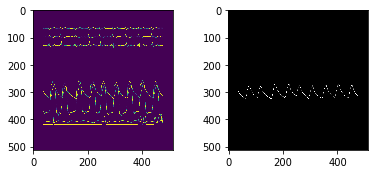

In [9]:
# Check to see if mask is saved correctly for training set
image_batch, mask_batch = next(train_gen)

r = random.randint(0, len(image_batch)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(image_batch[r], (SIZE, SIZE)))
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(mask_batch[r], (SIZE, SIZE)), cmap="gray")

# Training

In [10]:
m = model.unet(input_size= (SIZE, SIZE, channel))

W0801 22:21:07.152581 4623562176 deprecation_wrapper.py:119] From /Users/dnguyen4/anaconda3/envs/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0801 22:21:07.190024 4623562176 deprecation_wrapper.py:119] From /Users/dnguyen4/anaconda3/envs/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0801 22:21:07.204518 4623562176 deprecation_wrapper.py:119] From /Users/dnguyen4/anaconda3/envs/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0801 22:21:07.243500 4623562176 deprecation_wrapper.py:119] From /Users/dnguyen4/anaconda3/envs/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Pl

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [11]:
import loss

In [12]:
batch_size = 5
NO_OF_TRAINING_IMAGES = len(os.listdir('train_frames/train/'))
NO_OF_VAL_IMAGES = len(os.listdir('val_frames/val/'))

NO_OF_EPOCHS = 50

BATCH_SIZE = batch_size

weights_path = 'weights/weights_00.h5'

opt = Adam(lr=1E-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

m.compile(loss=loss.dice_coef_loss,
          optimizer=opt,
          metrics=['acc', 'mae'])

checkpoint = ModelCheckpoint(filepath=weights_path, monitor='val_loss', 
                             verbose=1, save_best_only=True, save_weights_only=True)

csv_logger = CSVLogger('./log.out', append=True, separator=';')

earlystopping = EarlyStopping(monitor = 'val_loss', verbose = 1,
                              min_delta = 1e-4, patience = 2, mode = 'auto')

callbacks_list = [checkpoint, csv_logger, earlystopping]

# class_weights = {0: 1.,
#                  1: 197.}

In [14]:
start_time = time.time()
results = m.fit_generator(train_gen, epochs=NO_OF_EPOCHS, 
                          steps_per_epoch = (NO_OF_TRAINING_IMAGES//BATCH_SIZE),
                          validation_data=val_gen, 
                          validation_steps=(NO_OF_VAL_IMAGES//BATCH_SIZE), 
                          callbacks=callbacks_list)
time_passed = time.time() - start_time
# print('Ellapsed time: {}'.format(hms_string(time_passed))
m.save('Model_00.h5')
# print(str(time_passed))

Epoch 1/50
10/10 [==============================] - 297s 30s/step - loss: 0.9872 - acc: 0.1468 - mean_absolute_error: 0.5961 - val_loss: 0.9856 - val_acc: 0.4517 - val_mean_absolute_error: 0.5942

Epoch 00001: val_loss improved from inf to 0.98556, saving model to weights/weights_00.h5
Epoch 2/50
10/10 [==============================] - 284s 28s/step - loss: 0.9847 - acc: 0.6433 - mean_absolute_error: 0.5610 - val_loss: 0.9839 - val_acc: 0.5872 - val_mean_absolute_error: 0.6210

Epoch 00002: val_loss improved from 0.98556 to 0.98395, saving model to weights/weights_00.h5
Epoch 3/50
10/10 [==============================] - 294s 29s/step - loss: 0.9835 - acc: 0.8357 - mean_absolute_error: 0.5414 - val_loss: 0.9848 - val_acc: 0.6602 - val_mean_absolute_error: 0.6171

Epoch 00003: val_loss did not improve from 0.98395
Epoch 4/50
10/10 [==============================] - 290s 29s/step - loss: 0.9832 - acc: 0.8796 - mean_absolute_error: 0.5356 - val_loss: 0.9826 - val_acc: 0.6454 - val_mean_a

In [15]:
print ("It took {} hours to execute this".format((time_passed) / 3600.))

It took 0.4831904341114892 hours to execute this


# Evaluate model on test dataset

In [16]:
# Create testing dataset
test_frame_path = 'test_frames'
test_mask_path  = 'test_masks'

test_gen = data_gen(test_frame_path, test_mask_path, batch_size = batch_size)

In [17]:
# Loading test data
image_batch, mask_batch = next(test_gen)

In [18]:
m.metrics_names

['loss', 'acc', 'mean_absolute_error']

In [19]:
m.evaluate(x = image_batch,
               y = mask_batch,
               batch_size = batch_size)

5/5 [==============================] - 8s 2s/step


[0.9836971163749695, 0.735028088092804, 0.5987730026245117]

# Making predictions with model

In [20]:
def predict_one_mask():
    image_batch, mask_batch = next(test_gen)
#     print(type(image_batch))
#     print(type(mask_batch))
    predicted_mask_batch = m.predict(image_batch)
    image = image_batch[0]
#     print(type(predicted_mask_batch))
#     print(type(image))
    print(image.shape)
    predicted_mask = predicted_mask_batch[0].reshape(SIZE, SIZE)
    plt.imshow(image.squeeze())
    plt.imshow(predicted_mask, alpha=0.7)

(512, 512, 1)


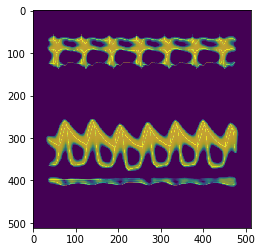

In [21]:
predict_one_mask()

In [22]:
image_batch, mask_batch = next(test_gen)
pred = m.predict(image_batch)
pred = pred > 0.5

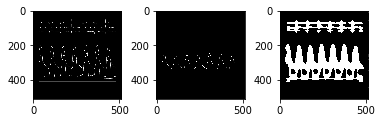

In [23]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.reshape(image_batch[0]*255, (SIZE, SIZE)), cmap='gray')

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(mask_batch[0]*255, (SIZE, SIZE)), cmap='gray')

ax = fig.add_subplot(1, 3, 3)
ax.imshow(np.reshape(pred[0]*255, (SIZE, SIZE)), cmap="gray")

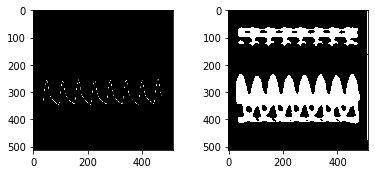

In [24]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(mask_batch[1]*255, (SIZE, SIZE)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(pred[1]*255, (SIZE, SIZE)), cmap="gray")